<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/EDA_realtime_volve_well_15_9_F_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The general idea of this notebook is to combine multiple sources of data: realtime drilling data and realtime trajectory in WITSML format, MWD-LWD data in LAS format, formation tops, and facies data, into one SUPERDATAFRAME.

The data used in this notebook is from well 15/9-F-15 in the Volve field. 

The output of this notebook is a trajectory visualization that shows all these combined data, at the same time. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from bs4 import BeautifulSoup
import plotly.express as px
import missingno as msno

!pip install lasio
import lasio

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets
from ipywidgets import interact, Dropdown

plt.style.use("classic")
from mpl_toolkits.mplot3d import Axes3D

In [2]:
!git clone https://github.com/yohanesnuwara/geostatistics

Cloning into 'geostatistics'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 177 (delta 12), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (177/177), 29.92 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (71/71), done.


## WITSML realtime drilling data

In [3]:
WITSML_file = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/00001.xml"

# Open the WITSML file
with open(WITSML_file) as file:
    data = file.read()
 
# Parse the file with Beautiful Soup
soup = BeautifulSoup(data, 'xml')

# Mnemonic list
mne = soup.find_all('mnemonicList')
lognames = mne[0].string.split(",") 

# Convert to Pandas dataframe
data = soup.find_all('data')
df = pd.DataFrame(columns=lognames,
                  data=[row.string.split(',') for row in data])

# Replace blank values with nan
df = df.replace('', np.nan)

# Convert to Pandas datetime
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Because TIME is not in the 1st column, move it to 1st column
df = df[ ['Time'] + [ col for col in list(lognames) if col != 'Time' ] ]

# Convert to numeric
cols = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

df.head()

,Time,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF
0,2013-11-28 12:54:29,3300,1280.0000,0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0
1,2013-11-28 16:48:21,3305,1280.0000,0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0
2,2013-11-28 17:01:59,3310,1315.2258,0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0
3,2013-11-28 17:46:39,3315,1320.0008,0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0
4,2013-11-28 18:02:50,3320,1320.0000,0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0


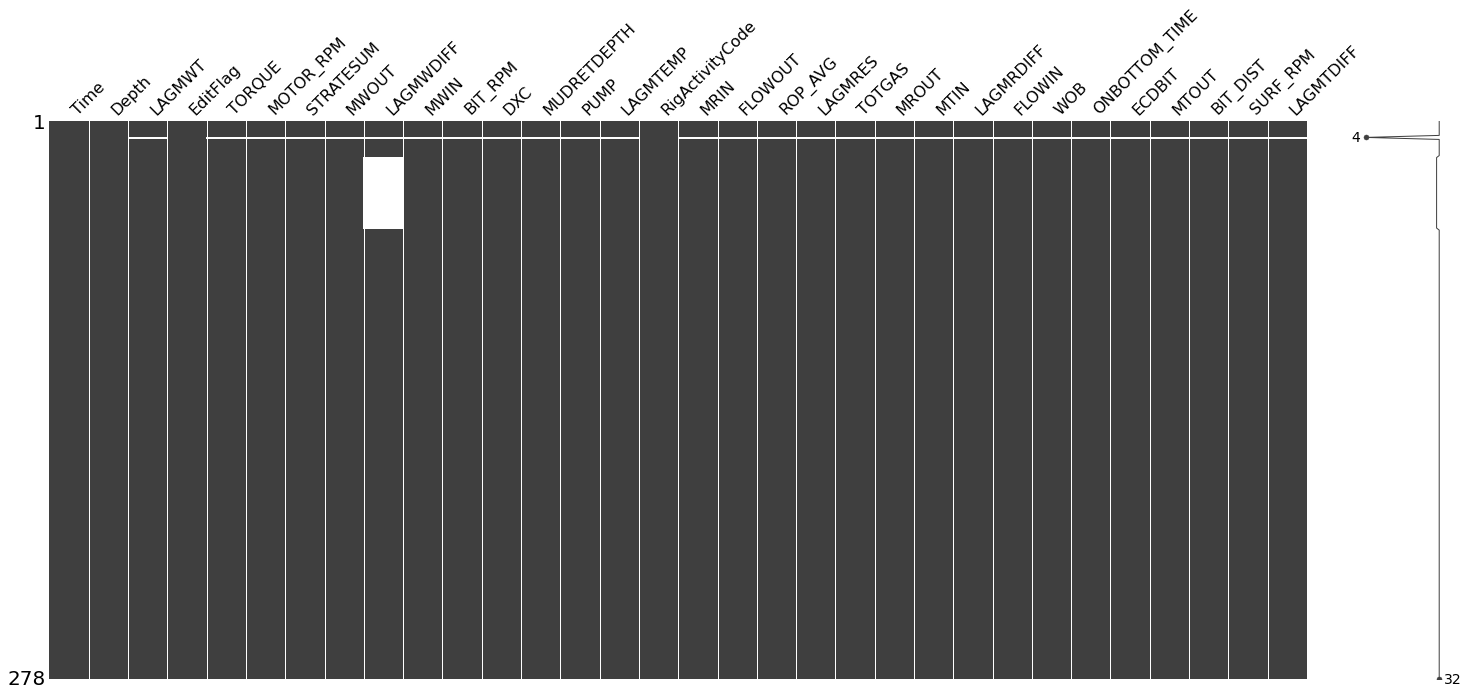

In [ ]:
msno.matrix(df)
plt.show()

## Interactive time series

In [ ]:
@interact

def f(y_axis=lognames, color_by=lognames):
  x_axis = df["Time"].values
  cont_color = ["blue", "green", "red", "yellow"]  
  fig = px.scatter(df, x="Time", y=y_axis, color=color_by,
                   range_x=(min(x_axis), max(x_axis)),
                   color_continuous_scale=cont_color,                   
                   width=1100, height=500)
  fig.show()

interactive(children=(Dropdown(description='y_axis', options=('Depth', 'LAGMWT', 'Time', 'EditFlag', 'TORQUE',…

## KDE plot

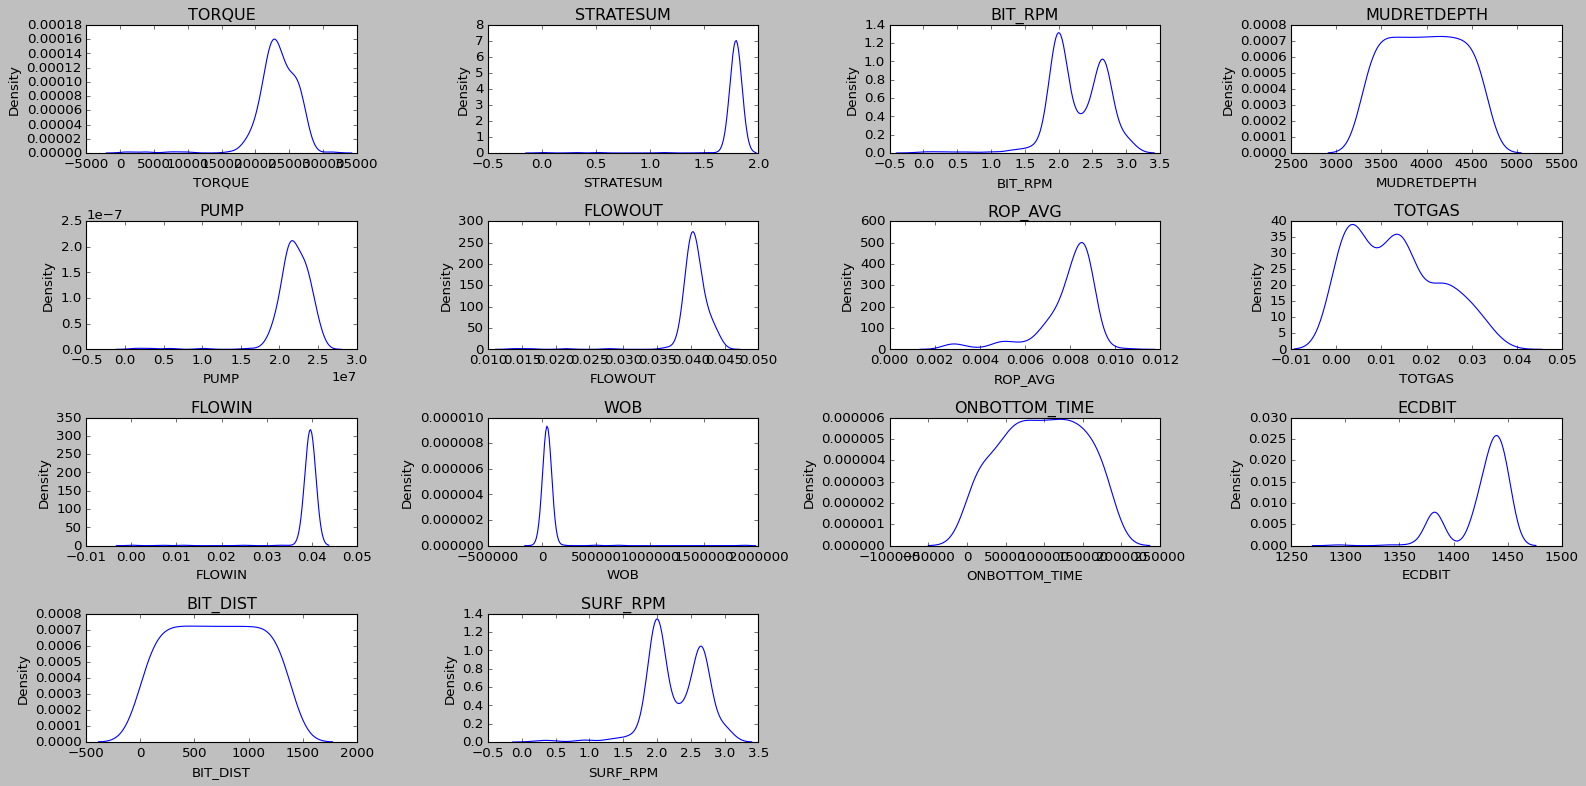

In [ ]:
plt.figure(figsize=(20,10))
for i in range(len(colnames)):
  plt.subplot(4,4,i+1)
  sns.kdeplot(df[colnames[i]])
  plt.title(colnames[i])
plt.tight_layout(1.1)
plt.show()

## Seaborn classical pairplot

Some drawbacks of seaborn pairplot are:
* For features > 7, plots become smaller and not too comfortable to look at.
* Takes quite a long time.
* Can't handle continuous hue. 

In my opinion, pairplot is not a good enough tool for EDA, but it's very useful when deciding when to normalize the data (see the distribution @ diagonal side) and to identify outliers (from the scatters).

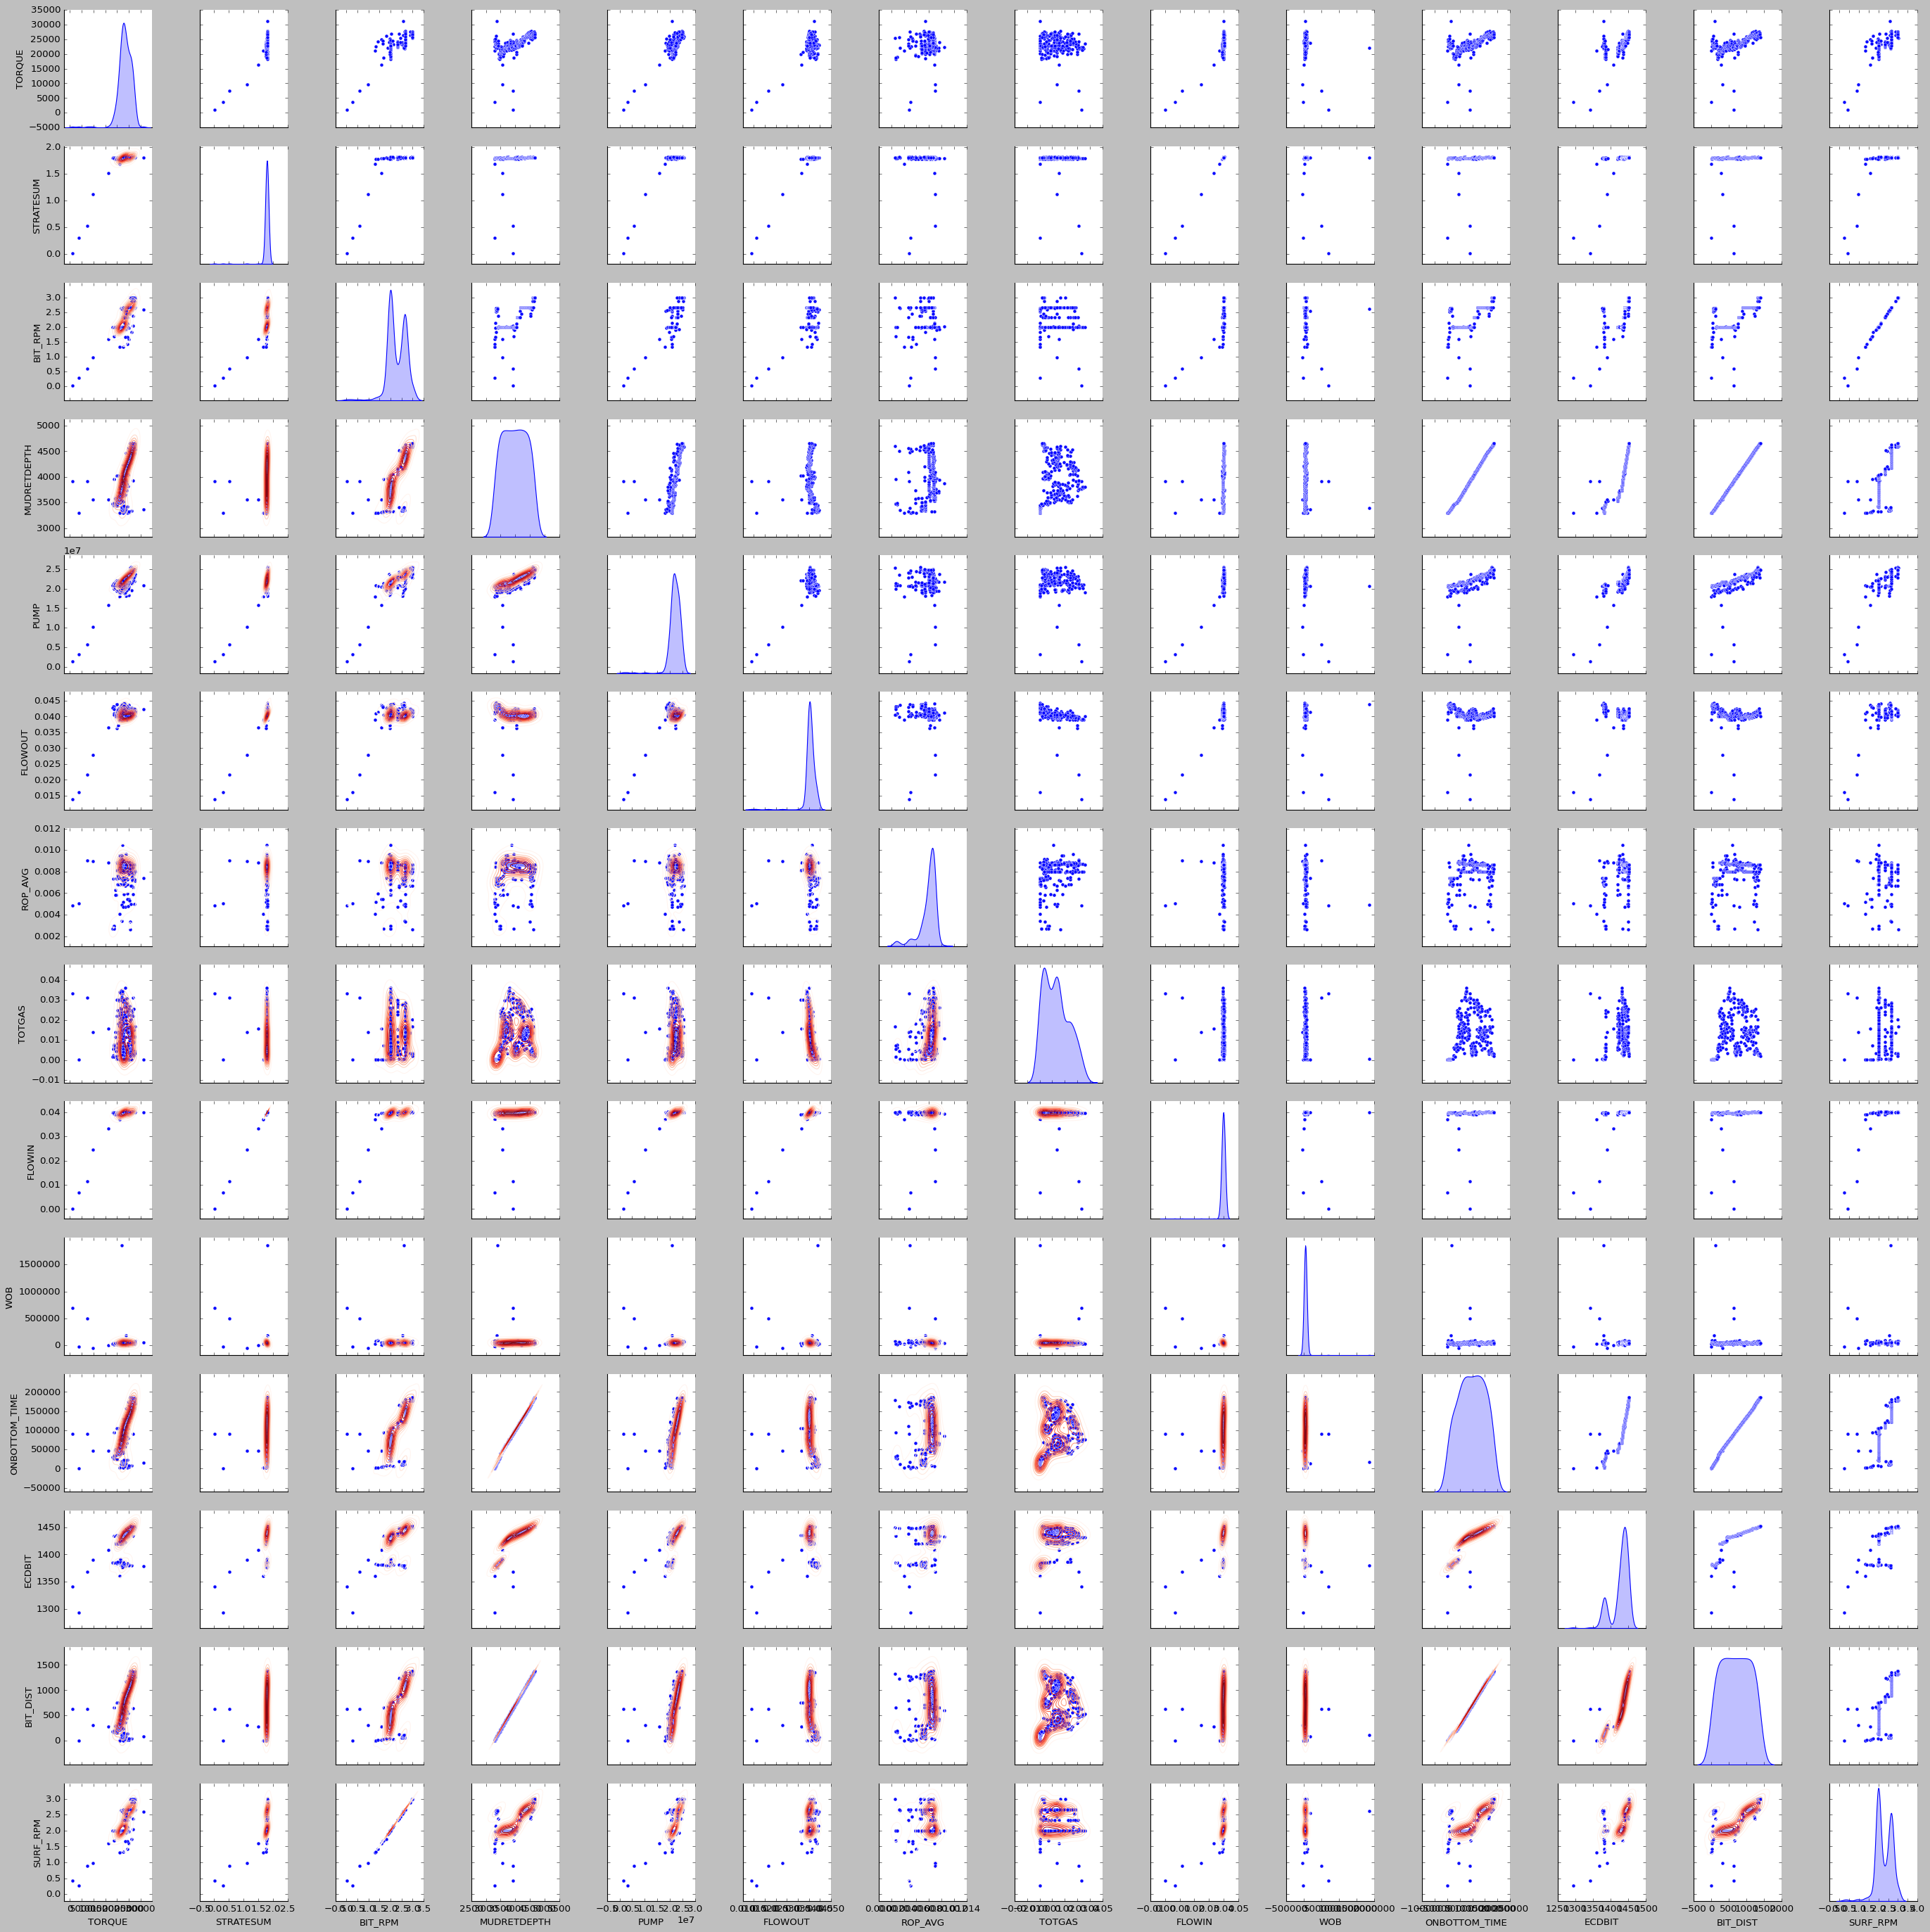

In [ ]:
# Features here are chosen, not all features (like the constant ones) are pairplotted. 
colnames = ["TORQUE", "STRATESUM", "BIT_RPM", "MUDRETDEPTH", "PUMP", "FLOWOUT",
            "ROP_AVG", "TOTGAS", "FLOWIN", "WOB", "ONBOTTOM_TIME", "ECDBIT",
            "BIT_DIST", "SURF_RPM"]

grid = sns.pairplot(df[colnames], diag_kind="kde")
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

plt.show()

## Interactive 2D scatter plot

As alternative to looking at confusing pairplot for EDA, I make an interactive 1-by-1 scatter plot, that can show continuous hue, and histograms at each axis.

In [ ]:
@interact

def f(x_axis=lognames, y_axis=lognames, color_by=lognames):
  fig = px.scatter(df, x=x_axis, y=y_axis, color=color_by,
                  marginal_x="histogram", marginal_y="histogram",
                  width=700, height=700)
  fig.show()

interactive(children=(Dropdown(description='x_axis', options=('Depth', 'LAGMWT', 'Time', 'EditFlag', 'TORQUE',…

## Interactive 3D scatter plot

Identify clusters in 3D

In [ ]:
@interact

def f(x_axis=lognames, y_axis=lognames, z_axis=lognames,
      color_by=lognames):
  fig = px.scatter_3d(df, x=x_axis, y=y_axis, z=z_axis,
                      color=color_by, width=700, height=700)
  fig.show()

interactive(children=(Dropdown(description='x_axis', options=('Depth', 'LAGMWT', 'Time', 'EditFlag', 'TORQUE',…

## WITSML realtime trajectory data

The realtime drilling data covers 3,300 to 4,685 m. The trajectory data covers to only 4,671 m. Therefore, from 3,300 to 4,671 m of realtime drilling data is covered by the trajectory, while the remaining 14 m is not. 

In [4]:
WITSML_file = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/trajectory2.xml"

# Reading the WITSML file
with open(WITSML_file) as file:
  data = file.read()

# Parse the WITSML file using the Beautiful library
soup = BeautifulSoup(data, 'xml')

# Convert to Pandas dataframe
data = soup.find_all('data')

# Print all tags (column names)
colnames = set([str(tag.name) for tag in soup.find_all()])

# Convert into dataframe with only selected column names
columns = ['azi', 'md', 'tvd', 'incl', 'dispNs', 'dispEw']
df2 = pd.DataFrame()
for col in columns:
    df2[col] = [float(x.text) for x in soup.find_all(col)]

df2.tail()

,azi,md,tvd,incl,dispNs,dispEw
109,107.51,4524.2000,3185.9439,77.65,201.7164,1449.4273
110,107.84,4564.9000,3193.8139,80.05,189.5929,1487.4710
111,108.48,4605.4030,3200.1182,82.04,177.1232,1525.4852
112,108.37,4645.7049,3205.6993,82.04,164.5080,1563.3527
113,107.27,4671.0000,3209.7608,79.48,156.8674,1587.1191


## WITSM realtime + trajectory

The realtime does not have X, Y, and Z (TVD) information. This info will be derived from the trajectory data. How to?

Interpolate X, Y, and Z on Measured Depth (MD) of trajectory, to create new X, Y, and Z values for given MDs of realtime data.

In [5]:
# x data is MD of traject, y data are dispNs, dispEw, and TVD of traject
xdata = df2["md"].values
ydata1, ydata2, ydata3 = df2["dispNs"].values, df2["dispEw"].values, df2["tvd"].values

# x new is MD of realtime
xnew = df["Depth"].values

# Thus y new will be dispNs, dispEw, and TVD in realtime
realtime_dispNs = [np.interp(i, xdata, ydata1) for i in xnew]
realtime_dispEw = [np.interp(i, xdata, ydata2) for i in xnew]
realtime_tvd = [np.interp(i, xdata, ydata3) for i in xnew]

# Add the interpolated values to new columns in realtime
df["TVD"] = realtime_tvd
df["dispNs"], df["dispEw"] = realtime_dispNs, realtime_dispEw 

## MWD data

There are two MWD data, measured in feet. The MWD 1, done on 21/01/2009, covers data from 2,524 to 3,669 m. The MWD 2, done on 28/01/2009, covers data from 3,500 to 4,090 m. 

The WITSML realtime drilling data covers data from 3,300 to 4,685 m. Therefore, the remaining 595 m is not covered by MWD data.

Long-term goal of this project (will be in another notebook), is predictive model for this 595 m of wellbore, DONE IN REALTIME.

In [6]:
LAS_file1 = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1~LF1~FRM1.las"
LAS_file2 = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_2~LF1~FRM1.las"

mwd1 = lasio.read(LAS_file1)
mwd2 = lasio.read(LAS_file2)

# Convert LAS to dataframe
mwd1_df = mwd1.df().reset_index()
mwd2_df = mwd2.df().reset_index()

mwd1_df.head()

,TDEP,6TIM,ROP5_RM,RFSA,RFSB,RFSL,RFSU,RFSR,QC_SIGM,QC_SPEC,WANH,WCLA,WCAR,WQFM,WPYR,WSID,WCOA,WEVA,CHY_WALK2,CSI_WALK2,CCA_WALK2,CCHL_WALK2,CFE_WALK2,CSUU_WALK2,CGD_WALK2,CTI_WALK2,CNC_WALK2,CK_WALK2,DWSI_WALK2,DWCA_WALK2,DWFE_WALK2,DWSU_WALK2,DWTI_WALK2,DWGD_WALK2,DWAL_WALK2,ASAL_WALK2,FY2W_WALK2,DXFE_WALK2,TAB_SPC,SIFA,...,NER2R,FAR1,FAR2,FAR1B,FAR2B,FAR1L,FAR2L,FAR1U,FAR2U,FAR1R,FAR2R,TNPH,TNPB,TNPL,TNPU,TNPR,BPHI,BPHB,BPHL,BPHU,BPHR,TNPH_UNC,TNPB_UNC,TNPL_UNC,TNPU_UNC,TNPR_UNC,BPHI_UNC,BPHB_UNC,BPHL_UNC,BPHU_UNC,BPHR_UNC,DBPHI,DBPHB,DBPHL,DBPHU,DBPHR,QC_BPHI,QC_TNPH,TAB_NEU,MONT
0,8284.0,7197450.0,19.6651,33.2073,31.0818,31.5009,34.1345,35.1409,0.0,0.696035,0.0,72.9994,1.68169,23.4180,0.000000,1.90089,0.0,0.0,4.94545,13.1697,3.718180,16.7303,34.9698,-0.893939,6.27273,-1.124240,12.2545,0.0,19.4644,3.413270,8.52876,0.000000,0.000000,3.19686,12.4908,53.1869,1.47797,0.912428,46730.0,29.3080,...,4755.90,39.8357,38.4579,40.4591,36.8851,39.8449,37.9403,40.4844,39.0243,39.2392,38.9647,55.3572,58.1975,55.4118,52.9849,57.9825,49.2305,50.6883,49.2591,47.9560,50.5806,52.0208,54.5916,52.0704,49.8649,54.3974,46.4587,47.8576,46.4863,45.2373,47.7540,0.000947,0.001142,0.000825,0.000709,0.001283,0.0,0.0,46686.0,4509.45
1,8284.5,7198850.0,19.6642,32.7742,29.1075,31.0000,34.0325,33.4475,0.0,0.699220,0.0,74.1390,0.00000,23.2063,0.000000,2.65473,0.0,0.0,4.78182,13.3879,1.863640,17.9121,35.0716,-0.984848,6.66667,-0.760606,11.6909,0.0,20.7643,1.795320,8.97614,0.000000,0.000000,3.56547,12.6311,58.5586,1.55098,1.274270,46724.0,28.8428,...,4695.35,41.6875,40.0194,41.1213,49.2230,40.9159,39.6693,40.7369,36.6085,43.3798,38.3594,50.0875,40.9824,50.9796,56.1066,51.2351,46.3261,40.8128,46.8375,49.6239,46.9831,47.2197,38.8542,48.0347,52.6980,48.2680,43.6763,38.4180,44.1657,46.8351,44.3045,0.000356,-0.004618,0.000322,0.000855,0.000911,0.0,0.0,46680.0,4467.64
2,8285.0,7200150.0,19.6996,31.9100,33.0354,31.9809,29.5209,32.4818,0.0,0.783539,0.0,74.7036,0.00000,21.3821,0.000000,3.91435,0.0,0.0,4.76364,13.0424,0.445455,18.8030,35.1506,-0.821212,5.72727,-0.378788,11.5455,0.0,21.6375,0.459013,9.62294,0.000000,0.000000,3.27641,12.7002,61.5122,1.65901,1.878890,46720.0,28.0250,...,4716.68,40.6951,39.5915,41.8183,45.9518,38.4991,37.9916,37.9969,39.0723,43.5576,42.7021,51.4079,41.7988,57.3935,58.2347,45.1115,45.3416,39.7113,48.4617,48.8747,41.6667,48.4256,39.6076,53.8628,54.6229,42.6538,42.7348,37.3720,45.7205,46.1161,39.2293,0.000347,-0.007896,0.001063,0.001380,-0.002021,0.0,0.0,46676.0,4457.36
3,8285.5,7201550.0,19.7355,32.1745,31.3791,31.5091,29.5227,35.6791,0.0,0.830220,0.0,73.9052,0.00000,21.1337,0.000000,4.96111,0.0,0.0,4.56364,12.4970,-0.354545,18.3667,34.8368,-0.384848,7.45455,0.275758,11.9818,0.0,21.8818,0.000000,10.06570,0.000000,0.017244,4.50092,12.6024,62.6423,1.75097,2.381330,46714.0,28.3724,...,4806.66,41.7452,38.8090,41.2815,41.8916,45.9702,38.5195,39.6844,39.8782,43.7800,36.2158,54.3540,50.4164,48.4567,54.3061,57.4294,49.8758,47.6536,46.4871,49.8494,51.5071,51.1103,47.5222,45.7287,51.0667,53.8977,47.0775,44.9473,43.8309,47.0525,48.6441,0.001173,0.001000,0.000740,0.000929,0.001351,0.0,0.0,46670.0,4474.64
4,8286.0,7202950.0,19.7355,33.1691,31.7227,32.1618,33.1064,35.1136,0.0,0.864769,0.0,70.8281,0.00000,22.4436,0.269107,6.45923,0.0,0.0,4.27273,11.6545,0.436364,15.8364,35.5616,0.181818,7.18182,1.000000,12.1091,0.0,21.2060,0.493158,10.67760,0.143838,0.064984,4.50609,12.2210,57.9769,1.81955,3.225700,46708.0,29.3455,...,4802.10,40.3895,39.7321,39.7676,39.5247,42.6468,40.8567,39.4038,46.6364,34.5406,36.0095,55.6137,56.9776,47.8603,46.9075,79.9295,52.4629,53.2012,47.9086,47.3040,63.3773,52.2493,53.4845,45.1783,44.3039,73.8531,49.5612,50.2717,45.1904,44.6111,60.1262,0.000934,0.000899,0.000077,0.000469,0.000336,0.0,0.0,46664.0,4510.00


In [ ]:
mwd2_df.head()

,TDEP,6TIM,ROP5_RM,RFSA,RFSB,RFSL,RFSU,RFSR,QC_SIGM,QC_SPEC,WANH,WCLA,WCAR,WQFM,WPYR,WSID,WCOA,WEVA,CHY_WALK2,CSI_WALK2,CCA_WALK2,CCHL_WALK2,CFE_WALK2,CSUU_WALK2,CGD_WALK2,CTI_WALK2,CNC_WALK2,CK_WALK2,DWSI_WALK2,DWCA_WALK2,DWFE_WALK2,DWSU_WALK2,DWTI_WALK2,DWGD_WALK2,DWAL_WALK2,ASAL_WALK2,FY2W_WALK2,DXFE_WALK2,TAB_SPC,SIFA,...,NER2R,FAR1,FAR2,FAR1B,FAR2B,FAR1L,FAR2L,FAR1U,FAR2U,FAR1R,FAR2R,TNPH,TNPB,TNPL,TNPU,TNPR,BPHI,BPHB,BPHL,BPHU,BPHR,TNPH_UNC,TNPB_UNC,TNPL_UNC,TNPU_UNC,TNPR_UNC,BPHI_UNC,BPHB_UNC,BPHL_UNC,BPHU_UNC,BPHR_UNC,DBPHI,DBPHB,DBPHL,DBPHU,DBPHR,QC_BPHI,QC_TNPH,TAB_NEU,MONT
0,11483.001,7574450.0,478.857,31.75,31.75,31.75,31.75,31.75,0.0,2.94205,0.0,72.7674,0.0,27.2326,0.0,0.0,0.0,0.0,6.0,13.0,1.0,28.0,24.4,-5.0,7.0,-3.0,16.0,0.0,23.3785,1.11698,7.24086,0.0,0.0,4.34083,12.4621,71.9178,1.79834,0.0,286.0,27.7637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.0
1,11483.501,7574550.0,478.857,31.75,31.75,31.75,31.75,31.75,0.0,2.94205,0.0,72.7674,0.0,27.2326,0.0,0.0,0.0,0.0,6.0,13.0,1.0,28.0,24.4,-5.0,7.0,-3.0,16.0,0.0,23.3785,1.11698,7.24086,0.0,0.0,4.34083,12.4621,71.9178,1.79834,0.0,286.0,27.7637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.0
2,11484.001,7574550.0,478.857,31.75,31.75,31.75,31.75,31.75,0.0,2.94205,0.0,72.7674,0.0,27.2326,0.0,0.0,0.0,0.0,6.0,13.0,1.0,28.0,24.4,-5.0,7.0,-3.0,16.0,0.0,23.3785,1.11698,7.24086,0.0,0.0,4.34083,12.4621,71.9178,1.79834,0.0,288.0,27.7637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.0
3,11484.501,7574650.0,480.141,31.75,31.75,31.75,31.75,31.75,0.0,2.94205,0.0,72.7674,0.0,27.2326,0.0,0.0,0.0,0.0,6.0,13.0,1.0,28.0,24.4,-5.0,7.0,-3.0,16.0,0.0,23.3785,1.11698,7.24086,0.0,0.0,4.34083,12.4621,71.9178,1.79834,0.0,286.0,27.7637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.0
4,11485.001,7574650.0,483.350,31.75,31.75,31.75,31.75,31.75,0.0,2.94205,0.0,72.7674,0.0,27.2326,0.0,0.0,0.0,0.0,6.0,13.0,1.0,28.0,24.4,-5.0,7.0,-3.0,16.0,0.0,23.3785,1.11698,7.24086,0.0,0.0,4.34083,12.4621,71.9178,1.79834,0.0,288.0,27.7637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.0


In [7]:
# List all mnemonics and their descriptions

def list_mnemonics(lasfile):
  """
  List all available mnemonics and descriptions. 
  Outputs are in dictionary and dataframe
  """
  mnemonic_array, descr_array = [], []
  for i in range(len(lasfile.curves[:])):
    mnemonic = lasfile.curves[i].mnemonic
    descr = lasfile.curves[i].descr
    mnemonic_array.append(mnemonic)
    descr_array.append(descr)

  # Create into description
  mnemonic_df = pd.DataFrame({"Mnemonic": mnemonic_array, "Description": descr_array}) 

  # Create into dictionary
  mnemonic_dict = dict(zip(mnemonic_array, descr_array))  

  return mnemonic_df, mnemonic_dict

# Mnemonics of LAS file 1 and 2
mne_df1, mne_dict1 = list_mnemonics(mwd1)
mne_df2, mne_dict2 = list_mnemonics(mwd2)

print(mne_df1)
print(mne_df2)

    Mnemonic                                      Description
0       TDEP                               6-Inch Frame Depth
1       6TIM                                 6-in. Frame Time
2    ROP5_RM      Rate of Penetration, Averaged over Last 5ft
3       RFSA                     Raw Formation Sigma, Average
4       RFSB                      Raw Formation Sigma, Bottom
..       ...                                              ...
419    DBPHR  Best Thermal Neutron Porosity Correction, Right
420  QC_BPHI          Best Neutron Porosity Quality Indicator
421  QC_TNPH       Thermal Neutron Porosity Quality Indicator
422  TAB_NEU                           Neutron Time After Bit
423     MONT                 Neutron Monitor Total Count Rate

[424 rows x 2 columns]
    Mnemonic                                      Description
0       TDEP                               6-Inch Frame Depth
1       6TIM                                 6-in. Frame Time
2    ROP5_RM      Rate of Penetration, Average

I'll only pick several logs

In [8]:
# Selected LWD logs. Special here is Bit size (BS_ARC)
mwd_lognames = ["TDEP", "GRMA", "BCAV", "WCLA", "WCAR", "WQFM", 
                "RHOB", "BPHI", "PEF", "BS_ARC"]

# Select subset dataframe
mwd1_df = mwd1_df[mwd_lognames]
mwd2_df = mwd2_df[mwd_lognames]

mwd1_df.head()

,TDEP,GRMA,BCAV,WCLA,WCAR,WQFM,RHOB,BPHI,PEF,BS_ARC
0,8284.0,29.6139,15.1446,72.9994,1.68169,23.4180,2.03128,49.2305,60.3361,8.5
1,8284.5,30.2355,15.1291,74.1390,0.00000,23.2063,2.00606,46.3261,61.3447,8.5
2,8285.0,31.8206,14.0747,74.7036,0.00000,21.3821,2.01147,45.3416,58.5946,8.5
3,8285.5,30.4889,15.2500,73.9052,0.00000,21.1337,2.00483,49.8758,60.2625,8.5
4,8286.0,30.0100,15.2500,70.8281,0.00000,22.4436,2.04901,52.4629,60.5356,8.5


Merging the two dataframes, then summary statistics. Now the dataframe covers data of the whole section 



In [9]:
# Merging dataframes
mwd_df = pd.concat([mwd1_df, mwd2_df], axis=0)

# Converting ft to m
mwd_df["TDEP"] = mwd_df["TDEP"] / 3.281

# Summary statistics
mwd_df.describe()

,TDEP,GRMA,BCAV,WCLA,WCAR,WQFM,RHOB,BPHI,PEF,BS_ARC
count,11383.000000,11028.000000,11008.000000,10872.000000,10872.000000,10872.000000,11010.000000,10475.000000,11010.000000,10990.0
mean,3334.337576,40.143142,8.656713,14.319751,35.994992,48.730271,2.465209,17.745643,8.944052,8.5
std,437.167645,54.749415,0.460286,17.648603,35.650104,30.375033,0.163013,10.109080,10.049985,0.0
min,2524.839988,4.588600,8.375790,0.000000,0.000000,0.000000,1.537190,2.849170,3.178270,8.5
25%,2958.473331,13.318575,8.544518,2.901600,0.000000,21.572675,2.330840,9.164395,5.928580,8.5
50%,3392.106370,29.298050,8.605040,8.063390,23.437450,45.685700,2.532880,14.337400,7.067555,8.5
75%,3662.755562,44.605375,8.680392,17.291575,73.041500,77.279025,2.599480,26.467700,7.664150,8.5
max,4089.454739,1065.610000,15.250000,75.342900,100.000000,100.000000,3.503930,94.503100,94.352300,8.5


## Ternary diagram of WQFM, WCLA, and WCAR

## WITSML + LWD = superdataframe

Previously, I merge the trajectory into WITSML realtime drilling by interpolation. Now, I merge the LWD data into it, by the same interpolation method.

In [12]:
def interpolate(df_data, df_new, x_data, y_data, x_new):
  xd, yd = df_data[x_data], df_data[y_data]
  xn = df_new[x_new]
  return np.interp(xn, xd, yd)

lognames_data = ["GRMA", "BCAV", "WCLA", "WCAR", "WQFM", "BPHI", "RHOB", "PEF"]

new_logs = []
for i in lognames_data:
  _ = interpolate(mwd_df, df, x_data="TDEP", y_data=i, x_new="Depth")
  new_logs.append(_)

# Merge the result to WITSML dataframe
for i in range(len(lognames_data)):
  df[lognames_data[i]] = new_logs[i]

df.head()

,Time,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,TVD,dispNs,dispEw,GRMA,BCAV,WCLA,WCAR,WQFM,BPHI,PEF,RHOB
0,2013-11-28 12:54:29,3300,1280.0000,0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,2847.175920,522.142441,328.097609,12.513936,8.638163,4.434944,80.266400,14.482249,16.946026,7.622013,2.470243
1,2013-11-28 16:48:21,3305,1280.0000,0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,2849.119298,522.341526,332.699357,10.280731,8.639613,10.098885,79.547450,8.585656,13.032502,7.699172,2.521753
2,2013-11-28 17:01:59,3310,1315.2258,0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,2851.062675,522.540610,337.301106,15.094298,8.591075,8.552648,73.030497,16.826583,13.578592,7.551022,2.531725
3,2013-11-28 17:46:39,3315,1320.0008,0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,2853.006053,522.739695,341.902855,13.801285,8.568848,3.779836,76.020705,19.718426,11.033525,7.236029,2.558482
4,2013-11-28 18:02:50,3320,1320.0000,0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,2854.949430,522.938780,346.504604,14.425436,8.623084,1.803262,79.936066,17.939404,8.607514,7.367780,2.601751


The superdataframe has been already CREATED !

## Adding formation tops

In [13]:
# Git clone my formation-evaluation library
!git clone https://github.com/yohanesnuwara/formation-evaluation

import sys
sys.path.append("/content/formation-evaluation")

from label_generator import label_generator

Cloning into 'formation-evaluation'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 114 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (114/114), 8.05 MiB | 2.82 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [14]:
# Path to well tops
topfile = "https://raw.githubusercontent.com/yohanesnuwara/volve-machine-learning/main/Volve_well_picks_modified.csv"

top_df = pd.read_csv(topfile)
top_df

,WELL,PICKS,OBS,QLF,DEPTH,TVD,TVDSS,TWT,DIP,AZI,EASTING,NORTHING,INTRP
0,NO 15/9-11,Seabed,1,NaN,113.0,113.00,-88.00,93.93,NaN,NaN,435410.8,6474001.6,STAT
1,NO 15/9-11,NORDLAND GP. Top,1,NaN,586.0,586.00,-561.00,629.45,NaN,NaN,435409.4,6474001.9,STAT
2,NO 15/9-11,Utsira Fm. Top,1,NaN,825.0,824.99,-799.99,869.89,NaN,NaN,435409.1,6474003.9,STAT
3,NO 15/9-11,HORDALAND GP. Top,1,NaN,1099.0,1098.96,-1073.96,1126.03,NaN,NaN,435412.3,6474005.4,STAT
4,NO 15/9-11,Ty Fm. Top,1,NaN,2387.0,2386.71,-2361.71,2298.79,3.18,19.0,435422.4,6473986.8,STAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,NO 15/9-F-7,HORDALAND GP. Top,1,NaN,1069.5,1064.13,-1009.23,925.89,NaN,NaN,434972.3,6478554.8,STAT
404,NO 15/9-F-9,Seabed,1,NaN,146.0,146.00,-91.10,120.38,NaN,NaN,435051.1,6478561.6,STAT
405,NO 15/9-F-9,NORDLAND GP. Top,1,NaN,146.0,146.00,-91.10,120.38,NaN,NaN,435051.1,6478561.6,STAT
406,NO 15/9-F-9,Utsira Fm. Top,1,NL,885.0,880.71,-825.81,883.79,NaN,NaN,435101.8,6478568.9,STAT


In [15]:
# Select tops of well 15/9-F-15 
top_df = top_df[top_df["WELL"].str.contains("15/9-F-15")]

# Make columns only consists of PICKS and DEPTH
top_df = top_df[["PICKS", "DEPTH"]].reset_index(drop=True)

top_df

,PICKS,DEPTH
0,Seabed,146.00
1,NORDLAND GP. Top,146.00
2,Utsira Fm. Top,901.27
3,HORDALAND GP. Top,1088.82
4,Ty Fm. Top,2672.41
...,...,...
59,Heather Fm. Top,3474.70
60,Hugin Fm. VOLVE Top,3483.20
61,Heather Fm. Top,4572.00
62,Heather Fm. Top,4572.00


Using "label_generator" function to generate formation top labels to the SUPERDATAFRAME.

In [16]:
# Generate top names inside new column "FM. LABEL"
df = label_generator(df, top_df, 'Depth', 'FM. LABEL')

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Time,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,TVD,dispNs,dispEw,GRMA,BCAV,WCLA,WCAR,WQFM,BPHI,PEF,RHOB,FM. LABEL
0,2013-11-28 12:54:29,3300,1280.0000,0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,2847.175920,522.142441,328.097609,12.513936,8.638163,4.434944,80.266400,14.482249,16.946026,7.622013,2.470243,Hod Fm. Top
1,2013-11-28 16:48:21,3305,1280.0000,0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,2849.119298,522.341526,332.699357,10.280731,8.639613,10.098885,79.547450,8.585656,13.032502,7.699172,2.521753,Hod Fm. Top
2,2013-11-28 17:01:59,3310,1315.2258,0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,2851.062675,522.540610,337.301106,15.094298,8.591075,8.552648,73.030497,16.826583,13.578592,7.551022,2.531725,Hod Fm. Top
3,2013-11-28 17:46:39,3315,1320.0008,0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,2853.006053,522.739695,341.902855,13.801285,8.568848,3.779836,76.020705,19.718426,11.033525,7.236029,2.558482,Hod Fm. Top
4,2013-11-28 18:02:50,3320,1320.0000,0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,2854.949430,522.938780,346.504604,14.425436,8.623084,1.803262,79.936066,17.939404,8.607514,7.367780,2.601751,Hod Fm. Top


From this, we get that the well penetrates from Hod Formation to Heather Formation. It hasn't yet hit Hugin, the oil-producing formation.

## Adding facies labels

In [17]:
faciesfile = "https://raw.githubusercontent.com/yohanesnuwara/geostatistics/main/data/volve-openhole/well_15_9_F-15/15_9-F-15_Facies.csv"

facies_df = pd.read_csv(faciesfile)

facies_df.head()

,* Well UWI,Common Well Name,* Litho Crv Type,* Source,* Top Depth (meters),* Base Depth (meters),Litho Class,Rock Percent (%),Original Data Source
0,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3954.8396,3962.5967,F-TIDAL BAR,100.0,NaN
1,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3962.5967,3974.5388,F-UPPER SHOREFACE,100.0,NaN
2,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3974.5388,3979.3984,F-TIDAL CHANNEL,100.0,NaN
3,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3979.3984,3981.0999,F-TIDAL FLAT SANDY,100.0,NaN
4,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3981.0999,3982.5698,F-OFFSHORE,100.0,NaN


In [18]:
# Make columns only consists of PICKS and DEPTH
facies_df = facies_df[["Litho Class", "* Top Depth (meters)"]].reset_index(drop=True)

facies_df.head()

,Litho Class,* Top Depth (meters)
0,F-TIDAL BAR,3954.8396
1,F-UPPER SHOREFACE,3962.5967
2,F-TIDAL CHANNEL,3974.5388
3,F-TIDAL FLAT SANDY,3979.3984
4,F-OFFSHORE,3981.0999


Adding the facies to the SUPERDATAFRAME

In [19]:
# Generate top names inside new column "FACIES"
df = label_generator(df, facies_df, 'Depth', 'FACIES')

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Time,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,TVD,dispNs,dispEw,GRMA,BCAV,WCLA,WCAR,WQFM,BPHI,PEF,RHOB,FM. LABEL,FACIES
0,2013-11-28 12:54:29,3300,1280.0000,0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,2847.175920,522.142441,328.097609,12.513936,8.638163,4.434944,80.266400,14.482249,16.946026,7.622013,2.470243,Hod Fm. Top,NaN
1,2013-11-28 16:48:21,3305,1280.0000,0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,2849.119298,522.341526,332.699357,10.280731,8.639613,10.098885,79.547450,8.585656,13.032502,7.699172,2.521753,Hod Fm. Top,NaN
2,2013-11-28 17:01:59,3310,1315.2258,0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,2851.062675,522.540610,337.301106,15.094298,8.591075,8.552648,73.030497,16.826583,13.578592,7.551022,2.531725,Hod Fm. Top,NaN
3,2013-11-28 17:46:39,3315,1320.0008,0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,2853.006053,522.739695,341.902855,13.801285,8.568848,3.779836,76.020705,19.718426,11.033525,7.236029,2.558482,Hod Fm. Top,NaN
4,2013-11-28 18:02:50,3320,1320.0000,0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,2854.949430,522.938780,346.504604,14.425436,8.623084,1.803262,79.936066,17.939404,8.607514,7.367780,2.601751,Hod Fm. Top,NaN


From this, we get that some portion of the realtime data can't be covered by facies data. 

## Finale: Superdataframe into CSV

In [20]:
df.to_csv("superdataframe_realtime_volve_15_9_F-15.csv", index=False)

## Finale: Trajectory visualization

Now, I have all data combined into one SUPERDATAFRAME. Our records are the realtime drilling data, trajectory, MWD-LWD, formation tops, and facies labels. Now let's get to viz. 

In [ ]:
# Convert datetime to string and add new column. This is for hovering data.
df["Time str"] = df["Time"].astype(str)
criteria = lognames + mwd_lognames + ["FM. LABEL", "FACIES"] # combine all data columns

@interact
def f(color_by=criteria):
  fig = px.scatter_3d(df, x="dispNs", y="dispEw", z="TVD",
                      color=color_by, hover_data=["Time str"],
                      width=1100)
  fig.show()

interactive(children=(Dropdown(description='color_by', options=('Depth', 'LAGMWT', 'Time', 'EditFlag', 'TORQUE…

Interpolate depth-datetime of realtime data

In [ ]:
# Convert np.datetime64 format to datetime format
dt64 = df["Time"].values
dt = dt64.astype('datetime64[s]').tolist()

# Convert datetime to timestamps
import datetime, numpy as np
import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())

y = [toTimestamp(i) for i in dt]

# Interpolate Measured Depth to datetime
x = df["Depth"].values
x2 = df2["md"].values

# use np.interpolate(x_new, x_data, y_data)
y2 = [int(np.round(np.interp(i, x, y))) for i in x2]

# convert back timestamps to np.datetime64
y2 = [np.datetime64(i, 's') for i in y2]

NameError: ignored